### Work through the notebook

In [1]:
#import dependencies

%matplotlib inline

import math, time, random, datetime

# Data manipulation
import numpy as np
import pandas as pd

#Visualisation
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

In [2]:
#preproccessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize


In [3]:
#machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

#lets ignore  warnings for now
import warnings
warnings.filterwarnings('ignore')

### Loading the data

In [4]:
# import train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [5]:
# View the training data
train.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
len(train)

891

In [7]:
# View the test data
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [8]:
len(test)

418

In [9]:
# View the example_submission dataframe
gender_submission.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Data Description
survived 0= No., 1= Yes

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### What missing values are there?


<AxesSubplot:>

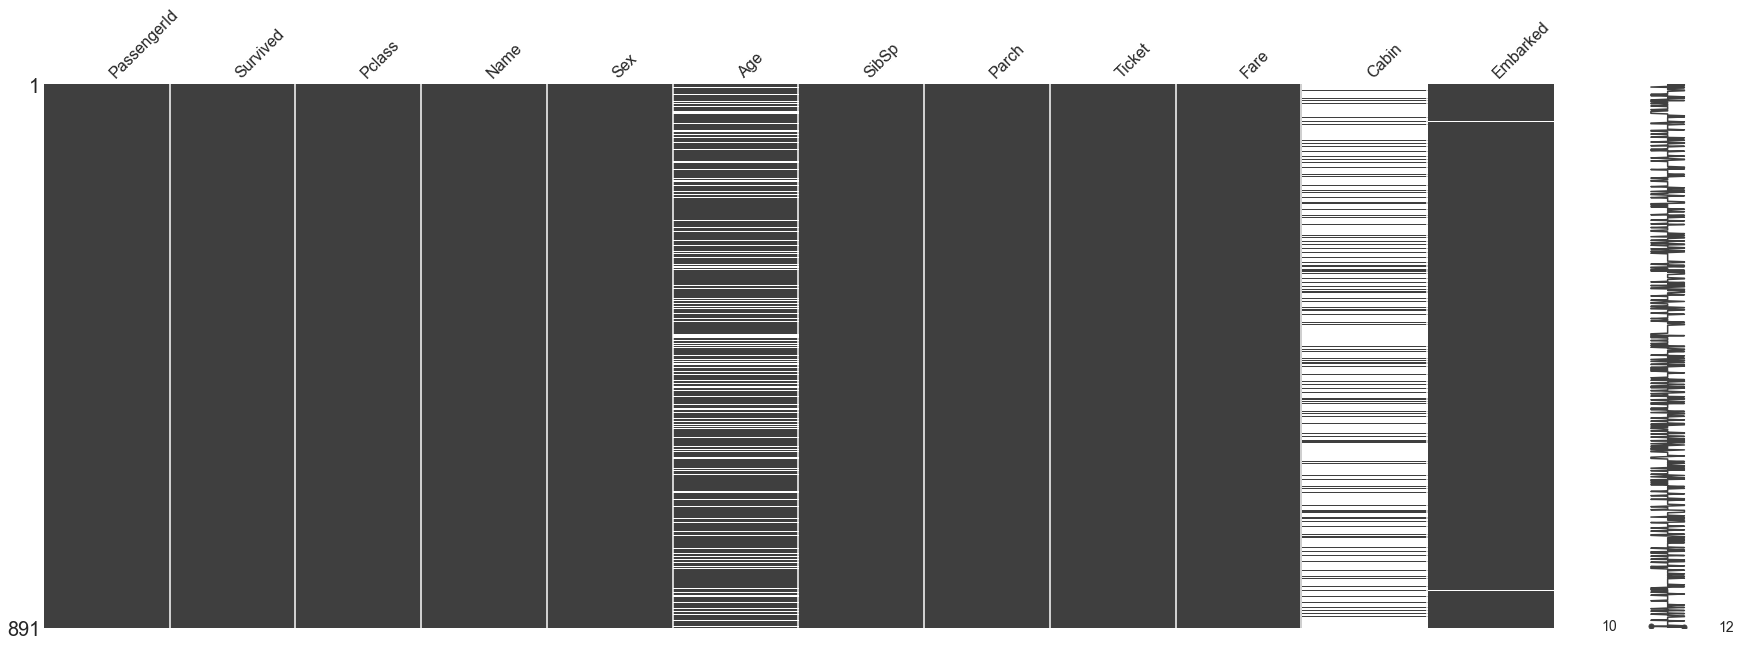

In [11]:
# plot graphic of missing values
missingno.matrix(train, figsize=(30,10))

In [12]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
## lets write a little function to show us how many missing values there are
def find_missing_values(df, columns):
    
    missing_vals = {}
    print('Number of missing or NaN values in each columns')
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length - total_column_values
        
    return missing_vals

missing_values = find_missing_values(train, columns = train.columns)
missing_values

Number of missing or NaN values in each columns


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

### To perform data analysis, lets create two new dataframes

In [14]:

df_bin = pd.DataFrame() # for discretised continuous variables 
df_con = pd.DataFrame() # for continuous variables

### What datatypes are in dataframes? 

In [15]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Lets explore each of these features individually

##### Target Feature : Survived
keys 0 = Not survived, 1 = survived

0    549
1    342
Name: Survived, dtype: int64


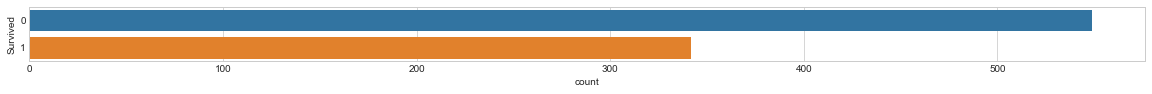

In [16]:
# how many perople survived
fig = plt.figure(figsize = (20,1))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

In [17]:
# Lets add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [18]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [19]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


#### Feature: Pclass
Descriptions: The tickets counts of the passenger
key: 1=1st, 2=2nd, 3=3rd

### Lets plot the distributions

<AxesSubplot:xlabel='Pclass', ylabel='Density'>

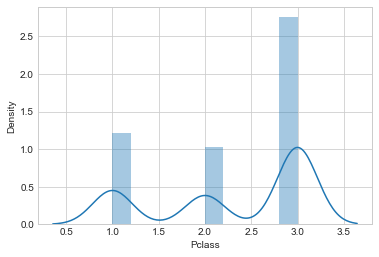

In [20]:
sns.distplot(train.Pclass)

In [21]:
missing_values['Pclass']

0

Sincerthere are no missing values in Pclass, lets add it to our sub dataframes

In [22]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

### Feature:Name
the name of the passengers

In [23]:
train.Name.value_counts()

Troupiansky, Mr. Moses Aaron      1
Van Impe, Mr. Jean Baptiste       1
Peuchen, Major. Arthur Godfrey    1
Milling, Mr. Jacob Christian      1
Gallagher, Mr. Martin             1
                                 ..
Mudd, Mr. Thomas Charles          1
Hanna, Mr. Mansour                1
Carter, Rev. Ernest Courtenay     1
Cribb, Mr. John Hatfield          1
West, Miss. Constance Mirium      1
Name: Name, Length: 891, dtype: int64

### Feature : Sex

<AxesSubplot:xlabel='count', ylabel='Sex'>

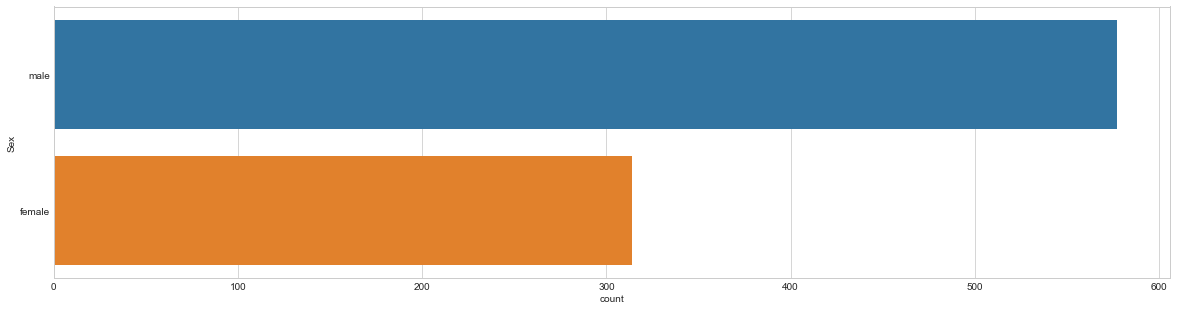

In [24]:
# Lets view the sex of passengers
plt.figure(figsize=(20,5))
sns.countplot(y='Sex', data = train)

In [25]:
missing_values['Sex']

0

In [26]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [27]:
# add sex to the dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0)

df_con['Sex'] = train['Sex']

In [28]:
df_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


<AxesSubplot:xlabel='Sex', ylabel='Density'>

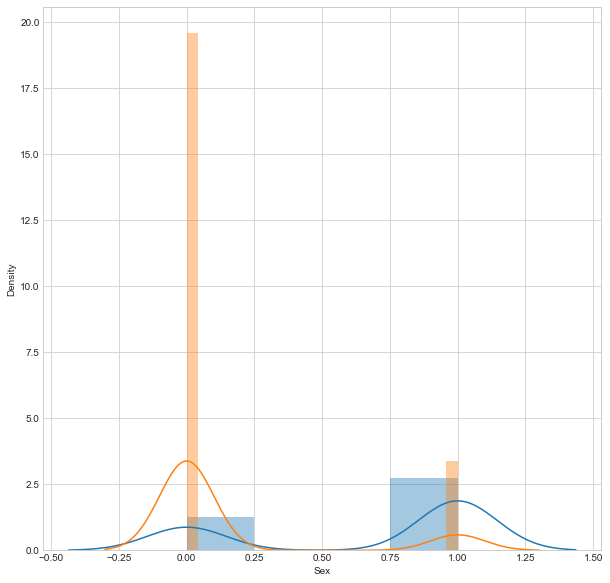

In [29]:
# How does sex variables look compared to survival?
fig = plt.figure(figsize=(10,10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'})
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': "Did not survived"})

### Feature : Age

In [30]:
missing_values['Age']

177

#### Function to create count and distribution visualization

In [31]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20,5), use_bin_df = False):
    
    if use_bin_df:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1,2,1)
        sns.countplot(y=target_column, data=bin_df)
        plt.subplot(1,2,2)
        sns.distplot(data.loc[data[label_column]==1][target_column],
                    kde_kws={'label':'survived'});
        sns.distplot(data.loc[data[label_column]==0][target_column],
                    kde_kws={'label': 'did not survive'})
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1,2,1)
        sns.countplot(y=target_column, data=data)
        plt.subplot(1,2,2)
        sns.distplot(data.loc[data[label_column]==1][target_column],
                            kde_kws={'label':'survived'});
        sns.distplot(data.loc[data[label_column]==0][target_column],
                        kde_kws={'label': 'did not survive'}) 

### Feature : SibSp


In [32]:
missing_values['SibSp']

0

In [33]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [34]:
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

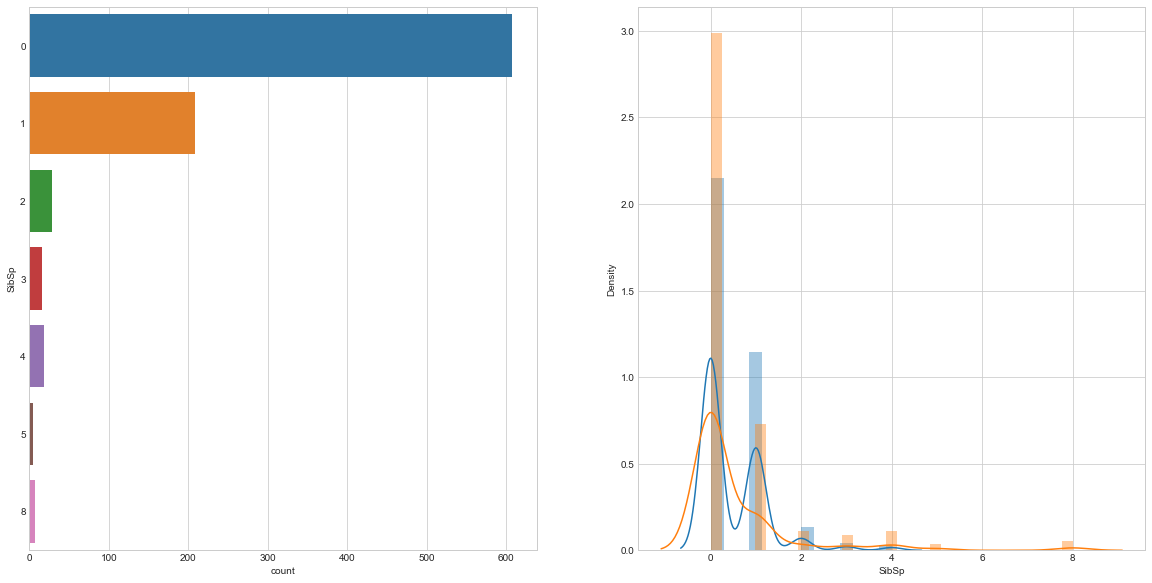

In [35]:
# Visualize the count of SibSp and the distribution of the values against survived
plot_count_dist(train,
               bin_df = bin,
               label_column='Survived',
               target_column = 'SibSp',
               figsize=(20,10))

### Feature: Parch
discription: The number of parents/children th epassenger has abord the Titanic

In [36]:
missing_values['Parch']

0

In [37]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [38]:
df_bin['Parch'] = train['Parch']
df_con["Parch"] = train['Parch']

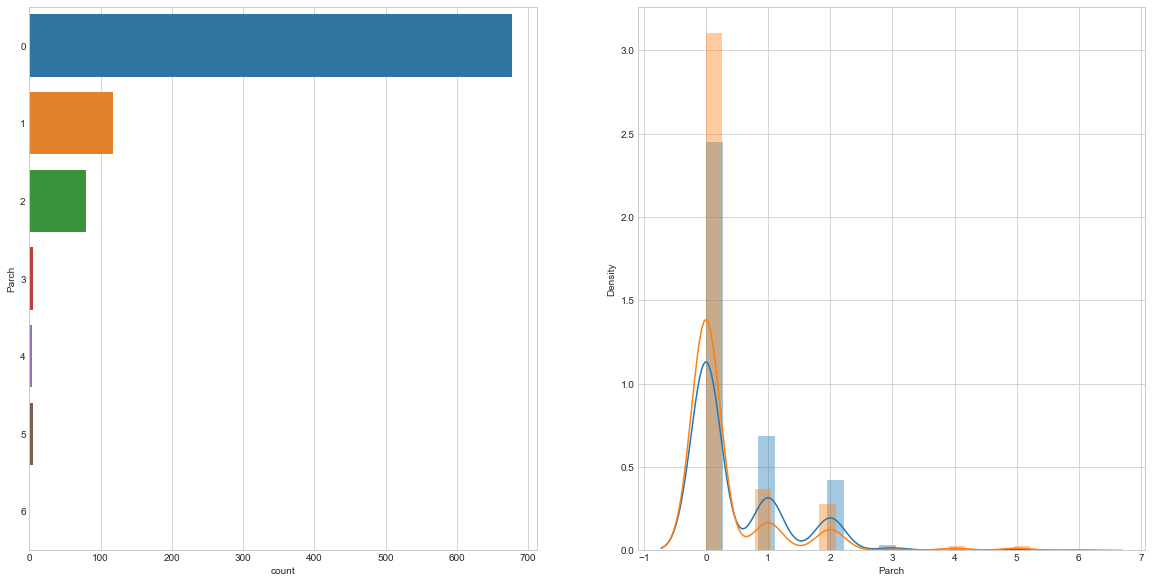

In [39]:
# Visualize the count of SibSp and the distribution of the values against survived
plot_count_dist(train,
               bin_df = df_bin,
               label_column='Survived',
               target_column = 'Parch',
               figsize=(20,10))

In [40]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,male,1,0
1,1,1,female,1,0
2,1,3,female,0,0
3,1,1,female,1,0
4,0,3,male,0,0


In [42]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,0,1,0
1,1,1,1,1,0
2,1,3,1,0,0
3,1,1,1,1,0
4,0,3,0,0,0


#### Feature : Tickets

In [43]:
missing_values['Ticket']

0

<AxesSubplot:xlabel='count', ylabel='Ticket'>

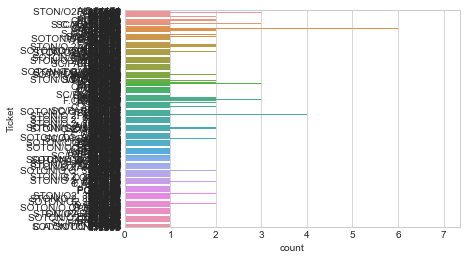

In [44]:
sns.countplot(y= 'Ticket', data = train
             )

In [45]:
train.Ticket.value_counts()

347082      7
1601        7
CA. 2343    7
CA 2144     6
347088      6
           ..
315089      1
345765      1
330935      1
365226      1
4135        1
Name: Ticket, Length: 681, dtype: int64

### Feature :  Fare

In [46]:
missing_values['Fare']

0

In [47]:
train.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

<AxesSubplot:xlabel='count', ylabel='Fare'>

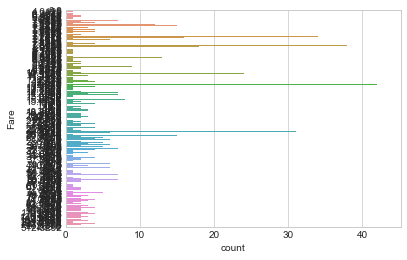

In [48]:
sns.countplot(y='Fare', data= train)

In [49]:
df_con['Fare'] = train['Fare']
df_bin['Fare'] = pd.cut(train['Fare'], bins=5)

In [50]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,0,1,0,"(-0.512, 102.466]"
1,1,1,1,1,0,"(-0.512, 102.466]"
2,1,3,1,0,0,"(-0.512, 102.466]"
3,1,1,1,1,0,"(-0.512, 102.466]"
4,0,3,0,0,0,"(-0.512, 102.466]"


In [51]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,male,1,0,7.2500
1,1,1,female,1,0,71.2833
2,1,3,female,0,0,7.9250
3,1,1,female,1,0,53.1000
4,0,3,male,0,0,8.0500


In [52]:
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

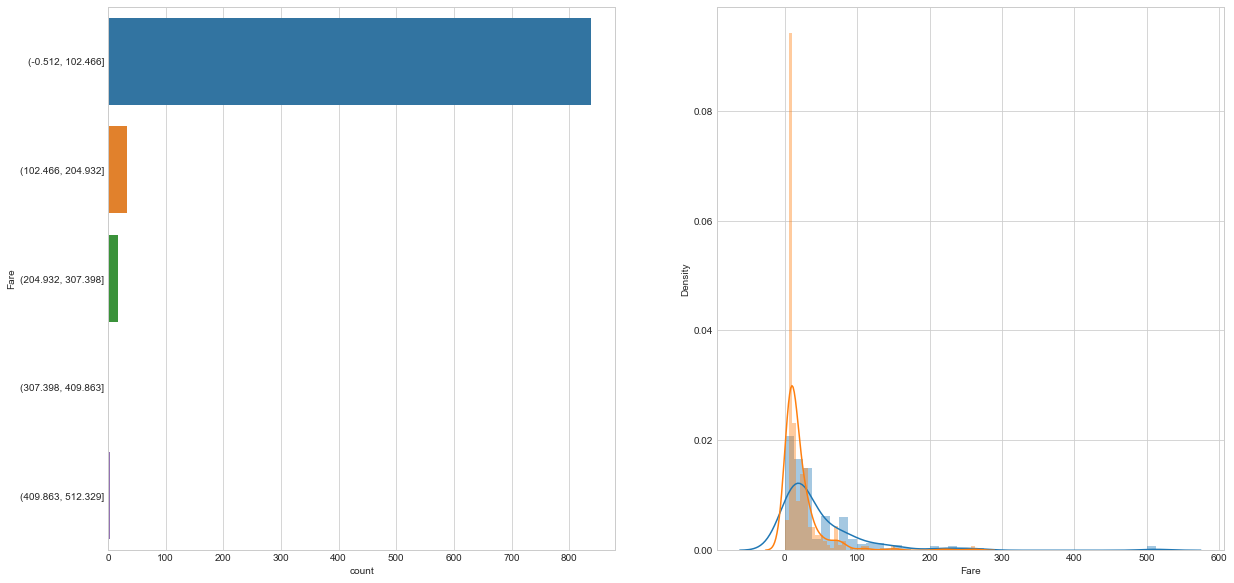

In [53]:
plot_count_dist(data=train,
               bin_df=df_bin,
               label_column='Survived',
               target_column='Fare',
               figsize=(20,10),
               use_bin_df=True)

### Feature : Cabin

In [54]:
missing_values['Cabin']

687

In [55]:
train.Cabin.value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
F2             3
C22 C26        3
              ..
F G63          1
D56            1
D47            1
C87            1
E34            1
Name: Cabin, Length: 147, dtype: int64

### Feature : Embarked

In [56]:
missing_values["Embarked"]

2

In [57]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<AxesSubplot:xlabel='count', ylabel='Embarked'>

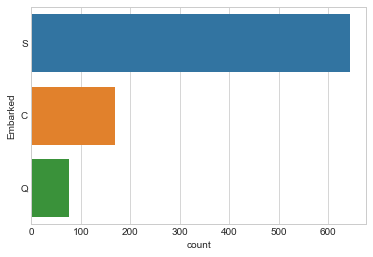

In [58]:
sns.countplot(y='Embarked', data= train)

In [59]:
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [60]:
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


### Feature Encoding

In [61]:
# One Hot Encoder
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_one = pd.get_dummies(df_bin, columns= one_hot_cols)
df_bin_one.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [62]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [63]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [64]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [65]:
# Let's look at df_con_enc
df_con_enc.head(20)

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1
5,0,0,0,8.4583,0,1,0,0,1,0,0,1
6,0,0,0,51.8625,0,0,1,0,1,1,0,0
7,0,3,1,21.0750,0,0,1,0,1,0,0,1
8,1,0,2,11.1333,0,0,1,1,0,0,0,1
9,1,1,0,30.0708,1,0,0,1,0,0,1,0


### Start Building some machine learning Models

#### Lets seperate the data

In [66]:
selected_df = df_con_enc

In [67]:
# Split the dataframe into data and labels
x_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived   # labels

In [68]:
x_train.shape

(889, 11)

In [69]:
y_train.shape

(889,)

#### Define a function to fit machine learning algorithms

In [70]:
# Function that runs the reqested algorithms and returns the accuracy metrics

def fit_ml_algo(algo, x_trian, y_train, cv):
    #one pass
    model = algo.fit(x_trian, y_train)
    acc = round(model.score(x_trian, y_train) * 100, 2)
    
    # Cross Validate
    train_pred = model_selection.cross_val_predict(algo,
                                                  x_train,
                                                  y_train,
                                                  cv= cv,
                                                  n_jobs=-1)
    #cross validation accuracy metrics
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [71]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),
                                                 x_train,
                                                 y_train,
                                                 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' %acc_log)
print('Accuracy cv 10-fold: %s' %acc_cv_log)
print('Running time : %s' %datetime.timedelta(seconds=log_time) )

Accuracy: 79.98
Accuracy cv 10-fold: 79.42
Running time : 0:00:05.849901


### K-Nearest Neighbours

In [72]:
start_time = time.time()
train_pred_log, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),
                                                 x_train,
                                                 y_train,
                                                 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' %acc_knn)
print('Accuracy cv 10-fold: %s' %acc_cv_knn)
print('Running time : %s' %datetime.timedelta(seconds=log_time) )

Accuracy: 83.46
Accuracy cv 10-fold: 76.72
Running time : 0:00:00.175916


### Gaussian Naive Bayes

In [73]:
start_time = time.time()
train_pred_log, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(),
                                                 x_train,
                                                 y_train,
                                                 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' %acc_gaussian)
print('Accuracy cv 10-fold: %s' %acc_cv_gaussian)
print('Running time : %s' %datetime.timedelta(seconds=log_time) )

Accuracy: 78.52
Accuracy cv 10-fold: 77.95
Running time : 0:00:00.062505


### Linear Support Vector Machines(SVC)

In [74]:
start_time = time.time()
train_pred_log, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                 x_train,
                                                 y_train,
                                                 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' %acc_linear_svc)
print('Accuracy cv 10-fold: %s' %acc_cv_linear_svc)
print('Running time : %s' %datetime.timedelta(seconds=log_time) )

Accuracy: 79.53
Accuracy cv 10-fold: 75.48
Running time : 0:00:00.890854


### Stochastic Gradient Descent

In [75]:
start_time = time.time()
train_pred_log, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(),
                                                 x_train,
                                                 y_train,
                                                 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' %acc_sgd)
print('Accuracy cv 10-fold: %s' %acc_cv_sgd)
print('Running time : %s' %datetime.timedelta(seconds=log_time) )

Accuracy: 75.59
Accuracy cv 10-fold: 68.39
Running time : 0:00:00.187532


### Decision Tree Classifier

In [76]:
start_time = time.time()
train_pred_log, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(),
                                                 x_train,
                                                 y_train,
                                                 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' %acc_dt)
print('Accuracy cv 10-fold: %s' %acc_cv_dt)
print('Running time : %s' %datetime.timedelta(seconds=log_time) )

Accuracy: 92.46
Accuracy cv 10-fold: 79.98
Running time : 0:00:00.257612


### Grdient Boost Tree

In [77]:
start_time = time.time()
train_pred_log, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(),
                                                 x_train,
                                                 y_train,
                                                 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' %acc_gbt)
print('Accuracy cv 10-fold: %s' %acc_cv_gbt)
print('Running time : %s' %datetime.timedelta(seconds=log_time) )

Accuracy: 86.61
Accuracy cv 10-fold: 80.65
Running time : 0:00:02.341599


## CatBoost Algorithm

In [78]:
x_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [79]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [80]:
cat_features = np.where(x_train.dtypes !=np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [81]:
train_pool = Pool(x_train, y_train, cat_features)

In [82]:
catboost_model = CatBoostClassifier(iterations=150,
                                   custom_loss=['Accuracy'],
                                   loss_function='Logloss')
# fit catboost model
catboost_model.fit(train_pool,
                  plot= True)
#Catboost accuracy
acc_catboost = round(catboost_model.score(x_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.055801
0:	learn: 0.6733251	total: 194ms	remaining: 28.8s
1:	learn: 0.6549783	total: 218ms	remaining: 16.1s
2:	learn: 0.6371961	total: 244ms	remaining: 12s
3:	learn: 0.6224876	total: 260ms	remaining: 9.5s
4:	learn: 0.6076925	total: 273ms	remaining: 7.92s
5:	learn: 0.5957293	total: 309ms	remaining: 7.42s
6:	learn: 0.5836791	total: 339ms	remaining: 6.93s
7:	learn: 0.5730251	total: 357ms	remaining: 6.34s
8:	learn: 0.5623655	total: 392ms	remaining: 6.15s
9:	learn: 0.5522024	total: 418ms	remaining: 5.85s
10:	learn: 0.5433123	total: 448ms	remaining: 5.66s
11:	learn: 0.5364816	total: 479ms	remaining: 5.51s
12:	learn: 0.5286590	total: 509ms	remaining: 5.36s
13:	learn: 0.5221704	total: 541ms	remaining: 5.25s
14:	learn: 0.5157180	total: 565ms	remaining: 5.08s
15:	learn: 0.5096528	total: 584ms	remaining: 4.89s
16:	learn: 0.5041134	total: 613ms	remaining: 4.79s
17:	learn: 0.4993054	total: 643ms	remaining: 4.72s
18:	learn: 0.4942954	total: 674ms	remaining: 4.65s
19:	learn: 0.4

### Perform catboost cross-validation

In [83]:
start_time = time.time()
cv_params = catboost_model.get_params()

cv_data = cv(train_pool,
            cv_params,
            fold_count=10,
            plot=True)
catboost_time = (time.time() - start_time)
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean'])*100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6741660	test: 0.6745459	best: 0.6745459 (0)	total: 2.75s	remaining: 6m 49s
1:	learn: 0.6562450	test: 0.6571612	best: 0.6571612 (1)	total: 5.53s	remaining: 6m 49s
2:	learn: 0.6410084	test: 0.6422451	best: 0.6422451 (2)	total: 8.17s	remaining: 6m 40s
3:	learn: 0.6265671	test: 0.6282010	best: 0.6282010 (3)	total: 10.9s	remaining: 6m 37s
4:	learn: 0.6126267	test: 0.6146019	best: 0.6146019 (4)	total: 14.2s	remaining: 6m 53s
5:	learn: 0.6001051	test: 0.6029237	best: 0.6029237 (5)	total: 19.5s	remaining: 7m 49s
6:	learn: 0.5878168	test: 0.5913229	best: 0.5913229 (6)	total: 23.6s	remaining: 8m 1s
7:	learn: 0.5796381	test: 0.5836389	best: 0.5836389 (7)	total: 26.8s	remaining: 7m 54s
8:	learn: 0.5691494	test: 0.5735432	best: 0.5735432 (8)	total: 30.8s	remaining: 8m 2s
9:	learn: 0.5588221	test: 0.5640187	best: 0.5640187 (9)	total: 33.8s	remaining: 7m 53s
10:	learn: 0.5515809	test: 0.5570707	best: 0.5570707 (10)	total: 37.3s	remaining: 7m 51s
11:	learn: 0.5425298	test: 0.5486976	best: 

92:	learn: 0.3923090	test: 0.4365981	best: 0.4365981 (92)	total: 7m	remaining: 4m 17s
93:	learn: 0.3917234	test: 0.4363625	best: 0.4363625 (93)	total: 7m 4s	remaining: 4m 12s
94:	learn: 0.3911946	test: 0.4363413	best: 0.4363413 (94)	total: 7m 9s	remaining: 4m 8s
95:	learn: 0.3909187	test: 0.4363626	best: 0.4363413 (94)	total: 7m 17s	remaining: 4m 5s
96:	learn: 0.3905077	test: 0.4363884	best: 0.4363413 (94)	total: 7m 23s	remaining: 4m 2s
97:	learn: 0.3900372	test: 0.4362518	best: 0.4362518 (97)	total: 7m 27s	remaining: 3m 57s
98:	learn: 0.3896727	test: 0.4363447	best: 0.4362518 (97)	total: 7m 32s	remaining: 3m 53s
99:	learn: 0.3894515	test: 0.4363183	best: 0.4362518 (97)	total: 7m 36s	remaining: 3m 48s
100:	learn: 0.3890219	test: 0.4362581	best: 0.4362518 (97)	total: 7m 42s	remaining: 3m 44s
101:	learn: 0.3885509	test: 0.4361010	best: 0.4361010 (101)	total: 7m 46s	remaining: 3m 39s
102:	learn: 0.3882332	test: 0.4359388	best: 0.4359388 (102)	total: 7m 51s	remaining: 3m 35s
103:	learn: 0.

In [84]:
print('---- CatBoost Metrics----')
print('Accuracy: {}'.format(acc_catboost))
print('Accuracy CV 10-fold: {}'.format(acc_cv_catboost))
print('Running Time : {}'.format(datetime.timedelta(seconds=catboost_time)))

---- CatBoost Metrics----
Accuracy: 82.79
Accuracy CV 10-fold: 81.21
Running Time : 0:11:35.489317


## Model Results

Which model had the best cross-validation accuracy?

**Note:** We care most about cross-validation metrics because the metrics we get from .fit() can randomly score higher than usual.

### Regular accuracy score

In [85]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes',
             'Stochastic Gradient Decent', 'Linear SVC', 
             'Decision Tree', 
              'GRadient Boosting Trees', 'CatBoost'],
    'Score': [acc_knn,
             acc_log,
             acc_gaussian,
             acc_sgd,
             acc_linear_svc,
             acc_dt,
             acc_gbt,
             acc_catboost]
})
print('---Regular Accuracy Scores-----')
models.sort_values(by='Score', ascending=False)

---Regular Accuracy Scores-----


,Model,Score
5,Decision Tree,92.46
6,GRadient Boosting Trees,86.61
0,KNN,83.46
7,CatBoost,82.79
1,Logistic Regression,79.98
4,Linear SVC,79.53
2,Naive Bayes,78.52
3,Stochastic Gradient Decent,75.59


In [86]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes',
             'Stochastic Gradient Decent', 'Linear SVC', 
             'Decision Tree', 
              'GRadient Boosting Trees', 'CatBoost'],
    'Score': [acc_cv_knn,
             acc_cv_log,
             acc_cv_gaussian,
             acc_cv_sgd,
             acc_cv_linear_svc,
             acc_cv_dt,
             acc_cv_gbt,
             acc_cv_catboost]
})
print('---Cross-validation Accuracy Scores-----')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores-----


,Model,Score
7,CatBoost,81.21
6,GRadient Boosting Trees,80.65
5,Decision Tree,79.98
1,Logistic Regression,79.42
2,Naive Bayes,77.95
0,KNN,76.72
4,Linear SVC,75.48
3,Stochastic Gradient Decent,68.39


### Feature Importance

In [87]:
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png')

,imp,col
4,0.863361,embarked_Q
5,1.446005,embarked_S
3,1.492499,embarked_C
8,1.690260,pclass_1
9,2.349957,pclass_2
0,3.536447,SibSp
1,6.589102,Parch
2,11.146075,Fare
10,14.160988,pclass_3
7,26.168515,sex_male


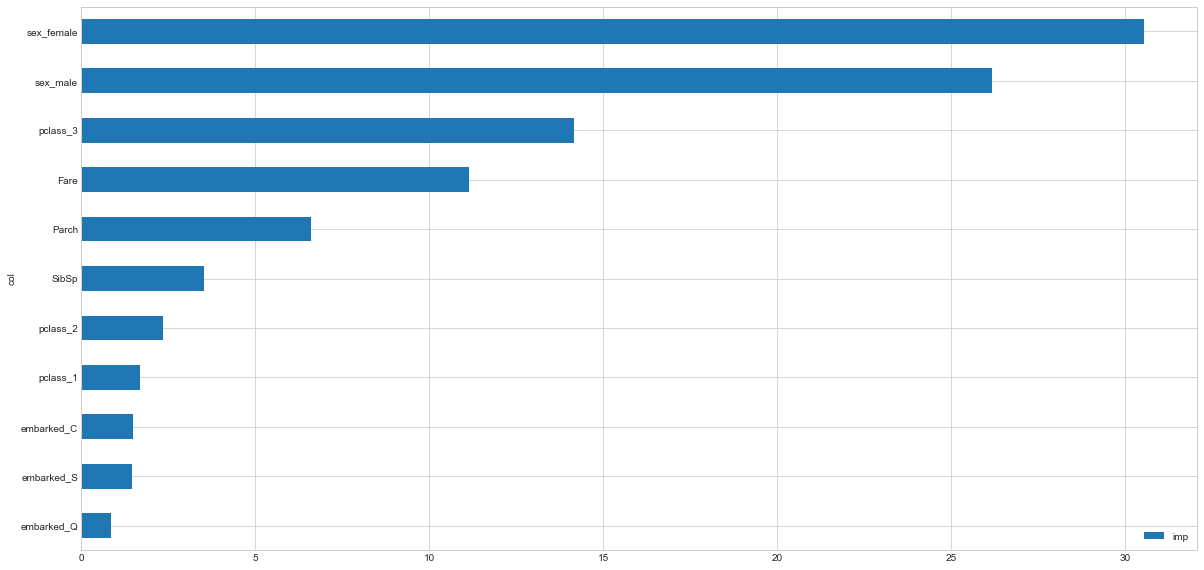

In [88]:
# Plot the feature importance scores
feature_importance(catboost_model, x_train)

## Precision and Recall

In [89]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8441102227363481
Recall: 0.6491960784313727
F1: 0.7337943459583596
AUC: 0.8711666309511054


## Submission

In [90]:
# We need our test dataframe to look like this one
x_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [91]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [92]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [93]:

# Combine the test one hot encoded columns with test
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [105]:
# Let's look at test, it should have one hot encoded columns now
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


In [106]:
# Create a list of columns to be used for the predictions
wanted_test_columns = x_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [107]:

# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns])

In [108]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
      dtype=int64)

In [109]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [110]:
# What does our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


We need our submission dataframe to look like the gender_submisison dataframe, so we'll turn the Survived column into integers.

In [111]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [112]:
# How does our submission dataframe look?
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [113]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [114]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [115]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
